In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.initializers import glorot_uniform
from tensorflow.keras import regularizers
from keras import Model
from keras import Input
from keras.utils import plot_model
from keras.layers import concatenate

import keras.backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load
from keras.models import load_model
import seaborn as sb
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

# comment the below line if you not using jupyter notebook
%matplotlib inline

In [2]:
print("Started reading the data for training...")
df_ = pd.read_csv('train.csv')
df = df_.copy()
# df_training = df.iloc[:,:].copy()
print("Finished reading the data")

Started reading the data for training...
Finished reading the data


In [3]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['color_type'])
df['color_type'] = le.transform(df['color_type'])

In [5]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,18,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,53,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,15,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,53,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,2,0.50,11.06,18,4,0.0,1


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc_y1 = OneHotEncoder(handle_unknown='ignore')
enc_y1.fit(df[['breed_category']])
y1 = enc_y1.transform(df[['breed_category']]).toarray()
enc_y2 = OneHotEncoder(handle_unknown='ignore')
enc_y2.fit(df[['pet_category']])
y2 = enc_y2.transform(df[['pet_category']]).toarray()

In [7]:
df[['condition']] = df[['condition']].fillna(3.0)

In [8]:
df.head()

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,18,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,53,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,3.0,15,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,53,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,2,0.50,11.06,18,4,0.0,1


In [9]:
x = df[['condition', 'color_type', 'length(m)', 'height(cm)', 'X1', 'X2']].values

In [10]:
def scaleData(x, y):
    sc_x = StandardScaler()
    sc_y = StandardScaler()

    sc_x.fit(x)
    sc_y.fit(y)
    
    return sc_x, sc_y

In [11]:
sc_x, sc_y = scaleData(x,y1)

In [12]:
x_scaled = sc_x.transform(x)

In [13]:
x_train = x_scaled[:15000,:]
y_train1 = y1[:15000,:]
y_train2 = y2[:15000,:]
x_val = x_scaled[15000:,:]
y_val1 = y1[15000:,:]
y_val2 = y2[15000:,:]

In [16]:
Kreg = regularizers.l2(1e-4)

inp = Input(shape = (x_train.shape[1],), name = 'x')
layer1 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 1), kernel_regularizer = Kreg)(inp)

layer2 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 2), kernel_regularizer = Kreg)(layer1)

layer3 = Dense(64, activation = 'relu',
                kernel_initializer = glorot_uniform(seed = 3), kernel_regularizer = Kreg)(layer2)

y1 = Dense(3, activation = 'sigmoid', name = 'y1',
                kernel_initializer = glorot_uniform(seed = 4), kernel_regularizer = Kreg)(layer3)

y2 = Dense(4, activation = 'sigmoid', name = 'y2',
                kernel_initializer = glorot_uniform(seed = 4), kernel_regularizer = Kreg)(layer3)

model = Model(
    inputs=inp,
    outputs=[y1, y2]
)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           448         x[0][0]                          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [53]:
adam = Adam(learning_rate = 0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics = ['categorical_accuracy'])

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model_cond-4-64-split.h5', monitor='loss', mode='min', save_best_only=True, verbose=1)
callbacks = [es, mc]

history = model.fit(
    x = {'x':x_train},
    y = {'y1':y_train1, 'y2':y_train2},
    epochs=100, batch_size=64,
    validation_data = ({'x':x_val},
                       {'y1':y_val1, 'y2':y_val2}),
    verbose = 1, callbacks = callbacks)

Epoch 1/100
207/235 [=========================>....] - ETA: 0s - loss: 0.5019 - y1_loss: 0.1443 - y2_loss: 0.3193 - y1_categorical_accuracy: 0.9130 - y2_categorical_accuracy: 0.8640
Epoch 00001: loss improved from inf to 0.50164, saving model to model_cond-4-64-split.h5
235/235 [==============================] - 1s 4ms/step - loss: 0.5016 - y1_loss: 0.1439 - y2_loss: 0.3195 - y1_categorical_accuracy: 0.9135 - y2_categorical_accuracy: 0.8644 - val_loss: 0.5895 - val_y1_loss: 0.1629 - val_y2_loss: 0.3883 - val_y1_categorical_accuracy: 0.8899 - val_y2_categorical_accuracy: 0.8417
Epoch 2/100
227/235 [===========================>..] - ETA: 0s - loss: 0.5019 - y1_loss: 0.1438 - y2_loss: 0.3197 - y1_categorical_accuracy: 0.9127 - y2_categorical_accuracy: 0.8645
Epoch 00002: loss did not improve from 0.50164
235/235 [==============================] - 1s 3ms/step - loss: 0.5017 - y1_loss: 0.1440 - y2_loss: 0.3194 - y1_categorical_accuracy: 0.9129 - y2_categorical_accuracy: 0.8651 - val_loss: 0

Epoch 16/100
229/235 [============================>.] - ETA: 0s - loss: 0.5000 - y1_loss: 0.1438 - y2_loss: 0.3178 - y1_categorical_accuracy: 0.9134 - y2_categorical_accuracy: 0.8645
Epoch 00016: loss did not improve from 0.50046
235/235 [==============================] - 1s 3ms/step - loss: 0.5009 - y1_loss: 0.1438 - y2_loss: 0.3186 - y1_categorical_accuracy: 0.9135 - y2_categorical_accuracy: 0.8645 - val_loss: 0.5899 - val_y1_loss: 0.1622 - val_y2_loss: 0.3892 - val_y1_categorical_accuracy: 0.8925 - val_y2_categorical_accuracy: 0.8414
Epoch 17/100
231/235 [============================>.] - ETA: 0s - loss: 0.5007 - y1_loss: 0.1438 - y2_loss: 0.3184 - y1_categorical_accuracy: 0.9126 - y2_categorical_accuracy: 0.8657
Epoch 00017: loss did not improve from 0.50046
235/235 [==============================] - 1s 3ms/step - loss: 0.5005 - y1_loss: 0.1438 - y2_loss: 0.3182 - y1_categorical_accuracy: 0.9123 - y2_categorical_accuracy: 0.8661 - val_loss: 0.5882 - val_y1_loss: 0.1621 - val_y2_los

Epoch 31/100
228/235 [============================>.] - ETA: 0s - loss: 0.4983 - y1_loss: 0.1435 - y2_loss: 0.3161 - y1_categorical_accuracy: 0.9123 - y2_categorical_accuracy: 0.8671
Epoch 00031: loss did not improve from 0.49960
235/235 [==============================] - 1s 3ms/step - loss: 0.4997 - y1_loss: 0.1436 - y2_loss: 0.3175 - y1_categorical_accuracy: 0.9123 - y2_categorical_accuracy: 0.8660 - val_loss: 0.5891 - val_y1_loss: 0.1621 - val_y2_loss: 0.3883 - val_y1_categorical_accuracy: 0.8915 - val_y2_categorical_accuracy: 0.8414
Epoch 32/100
213/235 [==========================>...] - ETA: 0s - loss: 0.4999 - y1_loss: 0.1423 - y2_loss: 0.3189 - y1_categorical_accuracy: 0.9145 - y2_categorical_accuracy: 0.8658
Epoch 00032: loss did not improve from 0.49960
235/235 [==============================] - 1s 3ms/step - loss: 0.4998 - y1_loss: 0.1436 - y2_loss: 0.3174 - y1_categorical_accuracy: 0.9131 - y2_categorical_accuracy: 0.8665 - val_loss: 0.5903 - val_y1_loss: 0.1620 - val_y2_los

Epoch 46/100
221/235 [===========================>..] - ETA: 0s - loss: 0.4974 - y1_loss: 0.1437 - y2_loss: 0.3148 - y1_categorical_accuracy: 0.9128 - y2_categorical_accuracy: 0.8668
Epoch 00046: loss did not improve from 0.49856
235/235 [==============================] - 1s 3ms/step - loss: 0.4989 - y1_loss: 0.1434 - y2_loss: 0.3166 - y1_categorical_accuracy: 0.9130 - y2_categorical_accuracy: 0.8662 - val_loss: 0.5881 - val_y1_loss: 0.1621 - val_y2_loss: 0.3872 - val_y1_categorical_accuracy: 0.8925 - val_y2_categorical_accuracy: 0.8417
Epoch 47/100
218/235 [==========================>...] - ETA: 0s - loss: 0.4966 - y1_loss: 0.1431 - y2_loss: 0.3147 - y1_categorical_accuracy: 0.9157 - y2_categorical_accuracy: 0.8667
Epoch 00047: loss did not improve from 0.49856
235/235 [==============================] - 1s 3ms/step - loss: 0.4988 - y1_loss: 0.1434 - y2_loss: 0.3165 - y1_categorical_accuracy: 0.9148 - y2_categorical_accuracy: 0.8665 - val_loss: 0.5888 - val_y1_loss: 0.1616 - val_y2_los

Epoch 61/100
228/235 [============================>.] - ETA: 0s - loss: 0.4989 - y1_loss: 0.1445 - y2_loss: 0.3154 - y1_categorical_accuracy: 0.9129 - y2_categorical_accuracy: 0.8661
Epoch 00061: loss did not improve from 0.49799
235/235 [==============================] - 1s 3ms/step - loss: 0.4982 - y1_loss: 0.1435 - y2_loss: 0.3157 - y1_categorical_accuracy: 0.9137 - y2_categorical_accuracy: 0.8659 - val_loss: 0.5884 - val_y1_loss: 0.1618 - val_y2_loss: 0.3875 - val_y1_categorical_accuracy: 0.8925 - val_y2_categorical_accuracy: 0.8409
Epoch 62/100
227/235 [===========================>..] - ETA: 0s - loss: 0.4985 - y1_loss: 0.1438 - y2_loss: 0.3156 - y1_categorical_accuracy: 0.9129 - y2_categorical_accuracy: 0.8659
Epoch 00062: loss improved from 0.49799 to 0.49794, saving model to model_cond-4-64-split.h5
235/235 [==============================] - 1s 3ms/step - loss: 0.4979 - y1_loss: 0.1434 - y2_loss: 0.3154 - y1_categorical_accuracy: 0.9139 - y2_categorical_accuracy: 0.8663 - val_l

Epoch 76/100
225/235 [===========================>..] - ETA: 0s - loss: 0.4969 - y1_loss: 0.1431 - y2_loss: 0.3144 - y1_categorical_accuracy: 0.9137 - y2_categorical_accuracy: 0.8667
Epoch 00076: loss did not improve from 0.49713
235/235 [==============================] - 1s 3ms/step - loss: 0.4972 - y1_loss: 0.1433 - y2_loss: 0.3146 - y1_categorical_accuracy: 0.9133 - y2_categorical_accuracy: 0.8665 - val_loss: 0.5897 - val_y1_loss: 0.1626 - val_y2_loss: 0.3877 - val_y1_categorical_accuracy: 0.8938 - val_y2_categorical_accuracy: 0.8414
Epoch 77/100
234/235 [============================>.] - ETA: 0s - loss: 0.4976 - y1_loss: 0.1434 - y2_loss: 0.3149 - y1_categorical_accuracy: 0.9131 - y2_categorical_accuracy: 0.8671
Epoch 00077: loss did not improve from 0.49713
235/235 [==============================] - 1s 3ms/step - loss: 0.4974 - y1_loss: 0.1432 - y2_loss: 0.3149 - y1_categorical_accuracy: 0.9133 - y2_categorical_accuracy: 0.8672 - val_loss: 0.5889 - val_y1_loss: 0.1625 - val_y2_los

Epoch 91/100
221/235 [===========================>..] - ETA: 0s - loss: 0.4987 - y1_loss: 0.1438 - y2_loss: 0.3154 - y1_categorical_accuracy: 0.9143 - y2_categorical_accuracy: 0.8676
Epoch 00091: loss improved from 0.49665 to 0.49616, saving model to model_cond-4-64-split.h5
235/235 [==============================] - 1s 3ms/step - loss: 0.4962 - y1_loss: 0.1430 - y2_loss: 0.3137 - y1_categorical_accuracy: 0.9150 - y2_categorical_accuracy: 0.8687 - val_loss: 0.5915 - val_y1_loss: 0.1621 - val_y2_loss: 0.3899 - val_y1_categorical_accuracy: 0.8920 - val_y2_categorical_accuracy: 0.8393
Epoch 92/100
214/235 [==========================>...] - ETA: 0s - loss: 0.4975 - y1_loss: 0.1433 - y2_loss: 0.3146 - y1_categorical_accuracy: 0.9137 - y2_categorical_accuracy: 0.8685
Epoch 00092: loss improved from 0.49616 to 0.49587, saving model to model_cond-4-64-split.h5
235/235 [==============================] - 1s 3ms/step - loss: 0.4959 - y1_loss: 0.1431 - y2_loss: 0.3133 - y1_categorical_accuracy: 0.

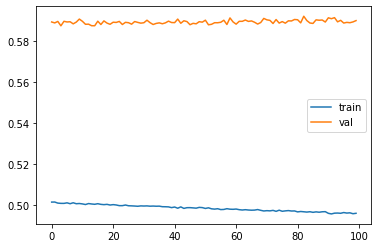

In [54]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

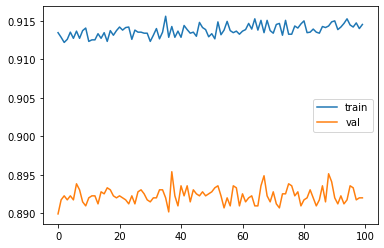

In [55]:
plt.figure()
plt.plot(history.history['y1_categorical_accuracy'], label='train')
plt.plot(history.history['val_y1_categorical_accuracy'], label='val')
plt.legend()
plt.show()

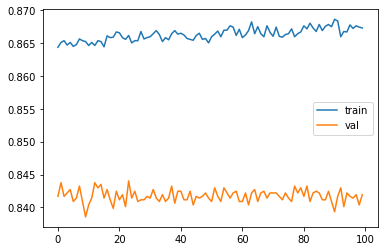

In [56]:
plt.figure()
plt.plot(history.history['y2_categorical_accuracy'], label='train')
plt.plot(history.history['val_y2_categorical_accuracy'], label='val')
plt.legend()
plt.show()

In [57]:
ymodel = model.predict(x_val)

In [58]:
ymodel1 = enc_y1.inverse_transform(ymodel[0])
y_act1 = enc_y1.inverse_transform(y_val1)
ymodel2 = enc_y2.inverse_transform(ymodel[1])
y_act2 = enc_y2.inverse_transform(y_val2)

In [59]:
from sklearn.metrics import f1_score

In [60]:
f1 = f1_score(ymodel1[:,0],y_act1[:,0],average='weighted')

In [61]:
f2 = f1_score(ymodel2[:,0],y_act2[:,0],average='weighted')

In [62]:
(f1+f2)*100/2

86.85649157670544

In [52]:
86.7250

86.725